# Нейрон с различными функциями активации

В этом задании нужно будет: 
- самостоятельно реализовать класс **`Neuron()`** с различными функциями активации (ReLU, LeakyReLU и ELU)

- обучить и протестировать этот класс на сгенерированных и реальных данных

**Достаточно реализовать ReLU и ещё одну из двух.**

In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

В данном случае мы снова решаем задачу бинарной классификации (2 класса: 1 или 0). Мы уже выяснили (в ноутбуке про `logloss`), что плохо брать для классификации квадратичную функцию потерь, однако здесь для простоты возьмём её:

$$
Loss(\hat{y}, y) = \frac{1}{n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2
$$  

Здесь $w \cdot X_i$ - скалярное произведение, а $\hat{y_i} = \sigma(w \cdot X_i) =\frac{1}{1+e^{-w \cdot X_i}} $ - сигмоида ($i$ -- номер объекта в выборке). 

In [3]:
def loss(y_pred, y):
    y_pred = y_pred.reshape(-1, 1)
    y = np.array(y).reshape(-1, 1)
    return 0.5 * np.mean((y_pred - y) ** 2)

Далее будут предложены несколько функций активации, и Вам нужно реализовать класс `Neuron` по аналогии с тем, как это было на семинаре. Сам принцип тот же, но меняются формула обновления весов и формула предсказания.

<h2 style="text-align: center;"><b>Нейрон с ReLU (Recitified Linear Unit)</b></h2>  

ReLU самая часто используемая (по крайней мере, пару лет назад) функция активации в нейронных сетях. Выглядит она очень просто:

\begin{equation*}
ReLU(x) =
 \begin{cases}
   0, &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Или по-другому:

$$
ReLU(x) = \max(0, x)
$$

В (свободном) переводе Rectified Linear Unit = "Усечённая линейная функция". Собственно, мы по сути просто не даём проходить отрицательным числам.

Производная здесь берётся как производная от кусочно-заданной функции, то есть на участках, где функция гладкая, и в нуле её доопредляют нулём:

\begin{equation*}
ReLU'(x) = 
 \begin{cases}
   0, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Подставим ReLu в Loss:

$$Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (ReLU(w \cdot X_i) - y_i)^2 = \begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n}
 \begin{cases}
    y_i^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$  

(помните, что $w \cdot X_i$ -- это число в данном случае (результат скалярного произведения двух векторов)).

Тогда формула для обновления весов при градиентном спуске будет такая (в матричном виде, рекмоендуем вывести самим то, как это получается из формулы для одного объекта):

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n}
 \begin{cases}
   0, &{w \cdot X_i \le 0}\\
   \frac{1}{n} X_i^T (w \cdot X_i - y), &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

(напоминаем, что здесь $w \cdot X$ -- матричное произведение вектора $w$ (ведь вектор -- тоже матрица, не так ли?) и матрицы $X$ )

Почему в первом случае будет 0? Потому что в формулу $y_i^2$ не входят веса , а мы берём производную именно по весам $w$.

* Реализуйте ReLU и её производную:

In [4]:
def relu(x):
    """ReLU-функция"""
    """
    if x > 0:
      return x
    else:
      return 0
    """
    return np.maximum(0, x)

def relu_derivative(x):
    """Производная ReLU"""
    return 1. * (x > 0)

Теперь нужно написать нейрон с ReLU. Здесь всё очень похоже на перцептрон, но будут по-другому обновляться веса и другая функция активации:

In [5]:
class NeuronReLU:
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        self.w = w
        self.b = b
        
        
    def activate(self, x):
        return relu(x)
        
        
    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрона при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрона 
        """
        y_pred = np.zeros((X.shape[0], 1))  # y_pred == y_predicted - предсказанные классы
        y_pred = self.activate(X @ self.w.reshape(X.shape[1], 1) + self.b)
        return y_pred.reshape(-1, 1)
    
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов нейрона в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        y = np.array(y).reshape(-1, 1)
        delta_w = (X.T @ ((y_pred - y) * relu_derivative(y_pred))) / len(y)
        delta_b = np.mean((y_pred - y) * relu_derivative(y_pred))
        self.w -= learning_rate * delta_w
        self.b -= learning_rate * delta_b
        
    
    def fit(self, X, y, num_epochs=300):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """
        self.w = np.random.rand(X.shape[1], 1)  # столбец (m, 1)
        self.b = np.random.rand(1)[0]  # смещение (число)
        loss_values = []  # значения функции потерь на различных итерациях обновления весов
        
        for i in range(num_epochs):
            y_pred = self.forward_pass(X)
            loss_values.append(loss(y_pred, y))
            self.backward_pass(X, y, y_pred)
        
        return loss_values

<h3 style="text-align: center;"><b>Тестирование нейрона с ReLU</b></h3>  

Здесь вам нужно самим протестировать новый нейрон **на тех же данных** ("Яблоки и Груши" и "Голос") по аналогии с тем, как это было проделано с перцептроном.
В итоге нужно вывести: 
* график, на котором будет показано, как изменяется функция потерь $Loss$ в зависимости от числа итераций обучения
* график с раскраской выборки нейроном

***ПРИМЕЧАНИЕ***: пожалуйста, почаще проверяйте `.shape` у матриц и векторов: `self.w`, `X` и `y` внутри класса. Очень часто ошибка решается транспонированием или `.reshape()`'ом. Не забывайте проверять, что на что Вы умножаете и какой вектор (какой размер) хотите получить на выходе -- это очень помогает не запутаться.

In [6]:
def plot_scatter(x1, x1_label, x2, x2_label, y, title):
  plt.figure(figsize=(15, 10))
  plt.scatter(x2, x1, c=y)
  plt.title(title)
  plt.xlabel(x1_label)
  plt.ylabel(x2_label)
  plt.show()

In [7]:
def plot(y, x_label, y_label, title):
  plt.figure(figsize=(15,10))
  plt.plot(y)
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.show()

In [8]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1lV5-8eXE1RWBfg37ijWcsSoJ-7rxassi"}) 
downloaded.GetContentFile('apples_pears.csv')
apples_pears = pd.read_csv('apples_pears.csv', sep=',')

downloaded = drive.CreateFile({'id':"1HXZfEZjFUCKYO-jpd6SY6oBh0ag0dEuV"}) 
downloaded.GetContentFile('voice.csv')
voice = pd.read_csv('voice.csv', sep=',')

del(downloaded)

In [9]:
plot_scatter(apples_pears['symmetry'], 'symmetry', 
             apples_pears['yellowness'], 'yellowness', 
             neuron.forward_pass(X).ravel(), 'apples and pears')

NameError: ignored

In [13]:
X = apples_pears[['yellowness', 'symmetry']].values
y = apples_pears[['target']].values.reshape((-1, 1))

In [14]:
#%%time
neuron = NeuronReLU()
loss_values = neuron.fit(X, y)

In [ ]:
plot(loss_values, 'номер итерации', '$Loss(\hat{y}, y)$', 'Функция потерь')

Скорее всего сейчас у вас лосс -- это прямая линия, и вы видите, что веса не обновляются. Но почему?

Всё просто -- если присмотреться, то видно, что self.w и self.b иницилизируются нулями в начале `.fit()`-метода. Если расписать, как будет идти обновление, то видно, что из-за ReLU веса просто-напросто не будут обновляться, если начать с инициализации нулями. 

Это -- одна из причин, по которой в нейронных сетях веса инициализируют случаными числами (обычно из отрезка [0, 1)).

Обучите нейрон, инициализировав случайно веса (поставьте 10000 итераций). 

Закомментируйте инициализацию нулями в функции `.fit()` класса `NeuronReLU` 

In [15]:
%%time
neuron_2 = NeuronReLU(w=np.random.rand(X.shape[1], 1), b=np.random.rand(1))
loss_values_2 = neuron_2.fit(X, y, num_epochs=20000)

CPU times: user 1.47 s, sys: 0 ns, total: 1.47 s
Wall time: 1.48 s


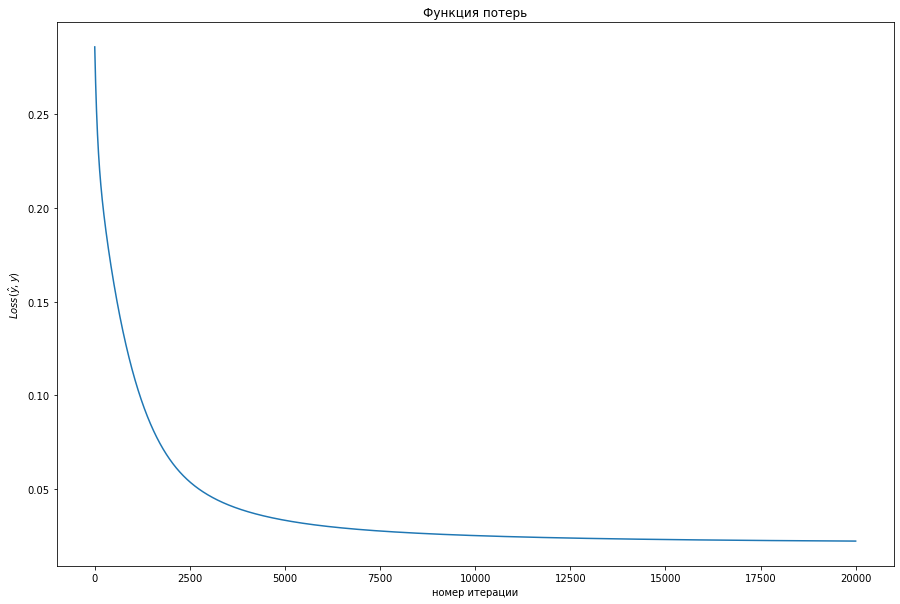

In [16]:
plot(loss_values_2, 'номер итерации', '$Loss(\hat{y}, y)$', 'Функция потерь')

Посмотрим, как предсказывает этот нейрон:

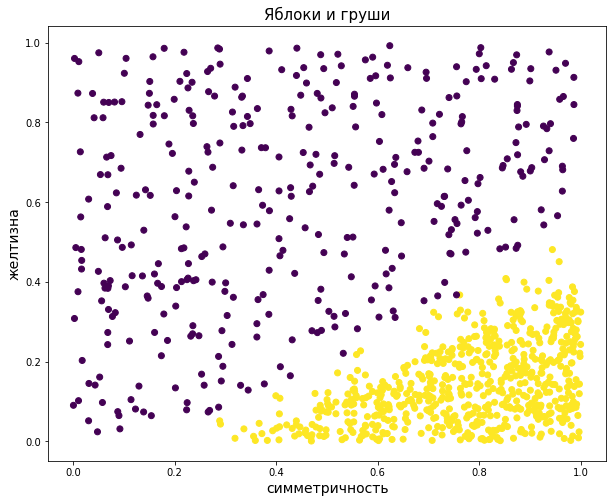

In [17]:
plt.figure(figsize=(10, 8))
plt.scatter(apples_pears.iloc[:, 0], apples_pears.iloc[:, 1], c=np.array(neuron_2.forward_pass(X) > 0.5).ravel())
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

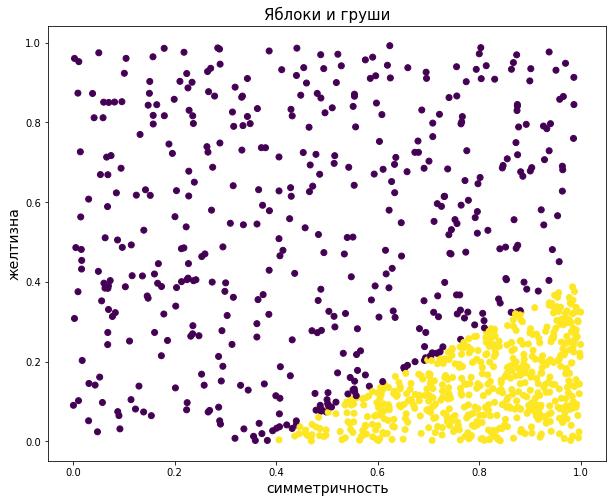

In [18]:
plt.figure(figsize=(10, 8))
plt.scatter(apples_pears.iloc[:, 0], apples_pears.iloc[:, 1], c=np.array(neuron_2.forward_pass(X) > 0.7).ravel())
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Почему-то не сработало на втором графике, не смотря на то, что обучение прошло успешно

Есть одна тенденция: пороговая функция активации и сигмоида (обычно всё же только сигмоида) чаще используются именно на **выходном слое** нейросети в задаче классификации -- ими предсказывают вероятности объектов принадлежать одному из классов, в то время как продвинутые функции активации (ReLU и те, что будут дальше) используются внутри нейросети, то есть в **скрытых слоях**.

Нужно понимать, что ReLU не может вернуть отрицательные числа.

**Плюсы ReLU:**

* дифференцируемая (с доопределе
нием в нуле)
* нет проблемы затухающих градиентов, как в сигмоиде

**Возможные минусы ReLU:**

* не центрирована около 0 (может мешать скорости сходимсти)
* зануляет все отрицательные входы, тем самым веса у занулённых нейронов могут часто *не обновляться*, эту проблему иногда называют *мёртвые нейроны*

С последней проблемой можно побороться, а именно:

<h2 style="text-align: center;"><b>Нейрон с LeakyReLU (Leaky Recitified Linear Unit)</b></h2>  

LeakyReLU очень слабо отличается от ReLU, но часто помогает сети обучаться быстрее, поскольку нет проблемы "мёртвых нейронов":

\begin{equation*}
LeakyReLU(x) =
 \begin{cases}
   \alpha x, &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

где $\alpha$ -- маленькое число от 0 до 1.

Производная здесь берётся так же, но вместо нуля будет $\alpha$:

\begin{equation*}
LeakyReLU'(x) = 
 \begin{cases}
   \alpha, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

График этой функции:

<img src="https://cdn-images-1.medium.com/max/1600/0*UtLlZJ80TMIM7kXk." width=400 height=300>

Подставим LeakyReLu в Loss:

$$
Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (LeakyReLU(w \cdot X_i) - y_i)^2 =
\begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n} 
 \begin{cases}
   (\alpha \cdot w \cdot X_i - y_i)^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}
$$  

Формула для обновления весов при градиентном спуске:

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n} 
 \begin{cases}
   \alpha X_i^T (w \cdot X_i - y), &{w \cdot X_i \le 0}\\
    X_i^T (w \cdot X_i - y), &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

* Реализуйте LeakyReLU и её производную:

In [10]:
def leaky_relu(x, alpha=0.01):
    """LeakyReLU-функция"""
    return np.maximum(0, x) + alpha * np.minimum(0, x)

def leaky_relu_derivative(x, alpha=0.01):
    """Производная LeakyReLU"""
    return 1. * (x > 0) + alpha * (x <= 0)

Теперь нужно написать нейрон с LeakyReLU функцией активации. Здесь всё очень похоже на перцептрон, но будут по-другому обновляться веса и другая функция активации:

In [11]:
class NeuronLeakyReLU:
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        self.w = w
        self.b = b
        
        
    def activate(self, x):
        return leaky_relu(x)
        
        
    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрона при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрона 
        """
        # y_pred == y_predicted - предсказанные классы
        y_pred = np.zeros((X.shape[0], 1))
        y_pred = self.activate(X @ self.w.reshape(X.shape[1], 1) + self.b)
        return y_pred.reshape(-1, 1)
        
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов нейрона в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        y = np.array(y).reshape(-1, 1)
        delta_w = (X.T @ ((y_pred - y) * relu_derivative(y_pred))) / len(y)
        delta_b = np.mean((y_pred - y) * relu_derivative(y_pred))
        self.w -= learning_rate * delta_w
        self.b -= learning_rate * delta_b
    
    
    def fit(self, X, y, num_epochs=300):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """
        self.w = np.random.rand(X.shape[1], 1)  # столбец (m, 1)
        self.b = np.random.rand(1)[0]  # смещение (число)
        loss_values = []  # значения функции потерь на различных итерациях обновления весов
        
        for i in range(num_epochs):
            y_pred = self.forward_pass(X)
            loss_values.append(loss(y_pred, y))
            self.backward_pass(X, y, y_pred)
        
        return loss_values

**Плюсы LeakyReLU:**

* дифференцируемая (с доопределнием в нуле)
* нет проблемы затухающих градиентов, как в сигмоиде
* нет проблемы "мёртвых нейронов", как в ReLU

**Возможные минусы LeakyReLU:**

* не центрирована около 0 (может мешать скорости сходимсти)
* немного не устойчива к "шуму" (см. лекции Стэнфорда)

In [12]:
%%time
neuron_3 = NeuronReLU(w=np.random.rand(X.shape[1], 1), b=np.random.rand(1))
loss_values_3 = neuron_3.fit(X, y, num_epochs=20000)

NameError: ignored

In [ ]:
data1 = go.Scatter(x=np.arange(20000), y=loss_values_2, name='ReLu')
data2 = go.Scatter(x=np.arange(20000), y=loss_values_3, name='LeakyReLU')
data = [data1, data2]
layout = {'title': 'Функции потерь'}
fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(loss_values_2, label='ReLU')
ax.plot(loss_values_3, label='LeakyReLU')
ax.set_title('Функции потерь')
ax.set_xlabel('номер итерации')
ax.set_ylabel('$Loss(\hat{y}, y)$')
ax.legend()

<h2 style="text-align: center;"><b>Нейрон с ELU (Exponential Linear Unit)</a></b></h2>  

ELU -- не так давно предложенная (в 2015 году) функция активации, которая, как говорят авторы статьи, лучше LeakyReLU. Вот формула ELU:

\begin{equation*}
ELU(\alpha, x) =
 \begin{cases}
   \alpha (e^x - 1), &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

где $\alpha$ -- маленькое число от 0 до 1.

Производная здесь берётся так же, но вместо нуля будет $\alpha$:

\begin{equation*}
ELU'(x) = 
 \begin{cases}
   ELU(\alpha, x) + \alpha, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Здесь в производной использован постой трюк -- сделано $- \alpha + \alpha$, чтобы вычислять было проще.

График этой функции:

<img src="http://p0.ifengimg.com/pmop/2017/0907/A004001DD141881BFD8AD62E5D31028C3BE3FAD1_size14_w446_h354.png" width=500 height=400>

Подставим LeakyReLu в Loss:

$$Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (ELU(\alpha, w \cdot X_i) - y_i)^2 = \begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n} 
 \begin{cases}
   (\alpha (e^{w \cdot X_i} - 1) - y_i)^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$  

Здесь вам нужно выписать самим град спуск для весов. Брать производную "в лоб" некрасиво и неудобно. Нужно воспользоваться **правилом цепочки**, оно же **правило взятия производной сложной функции**:

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n} 
 \begin{cases}
   , &{w \cdot X_i \le 0}\\
   , &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

* Реализуйте ELU и её производную:

In [ ]:
# Exponential linear unit

def elu(x, alpha=0.01):
    """функция"""
    return np.where(x >= 0, x, alpha*(np.exp(x) -1))

def elu_derivative(x, alpha=0.01):
    """Производная"""
    #return elu(x,a)+a if x <= 0 else 1
    return np.where(x <= 0, elu(x, alpha) + alpha, 1)

Теперь нужно написать нейрон с LeakyReLU функцией активации. Здесь всё очень похоже на перцептрон, но будут по-другому обновляться веса и другая функция активации:

In [ ]:
class NeuronELU:
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        self.w = w
        self.b = b
        
        
    def activate(self, x):
        return elu(x)
        
        
    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрона при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрона 
        """
        # y_pred == y_predicted - предсказанные классы
        y_pred = np.zeros((X.shape[0], 1))
        y_pred = self.activate(X @ self.w.reshape(X.shape[1], 1) + self.b)
        return y_pred.reshape(-1, 1)
        
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов нейрона в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        y = np.array(y).reshape(-1, 1)
        delta_w = (X.T @ ((y_pred - y) * relu_derivative(y_pred))) / len(y)
        delta_b = np.mean((y_pred - y) * relu_derivative(y_pred))
        self.w -= learning_rate * delta_w
        self.b -= learning_rate * delta_b
    
    
    def fit(self, X, y, num_epochs=300):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """
        self.w = np.random.rand(X.shape[1], 1)  # столбец (m, 1)
        self.b = np.random.rand(1)[0]  # смещение (число)
        loss_values = []  # значения функции потерь на различных итерациях обновления весов
        
        for i in range(num_epochs):
            y_pred = self.forward_pass(X)
            loss_values.append(loss(y_pred, y))
            self.backward_pass(X, y, y_pred)
        
        return loss_values

In [ ]:
class NeuronELU2:
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        self.w = w
        self.b = b
        
        
    def activate(self, x):
        return elu(x)
        
        
    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрона при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрона 
        """
        # y_pred == y_predicted - предсказанные классы
        y_pred = np.zeros((X.shape[0], 1))
        y_pred = self.activate(X @ self.w.reshape(X.shape[1], 1) + self.b)
        return y_pred.reshape(-1, 1)
        
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов нейрона в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        y = np.array(y).reshape(-1, 1)
        elu_derivative(y_pred)
        delta_w = (X.T @ ((y_pred - y) * relu_derivative(y_pred))) / len(y)
        delta_b = np.mean((y_pred - y) * relu_derivative(y_pred))
        self.w -= learning_rate * delta_w
        self.b -= learning_rate * delta_b
    
    def backward_pass_another(self, X, y, y_pred, learning_rate=0.1):   
        y = np.array(y).reshape(-1, 1)   
        a0 = y_pred
        a0 = elu_derivative(a0)
        da1 = y.shape[0] * 2 * (y_pred - y)
        da1 = np.array(da1).reshape(-1, 1)   
        da0 = np.multiply(np.multiply(a0, (1 - a0)), da1)
        self.w = self.w - learning_rate * np.dot(X.T, da0)
        #self.b = self.b - learning_rate * np.copy(da0) 
        self.b = self.b - learning_rate * np.mean(da0 - y)
        return np.dot(da0, self.w.T)

    
    def fit(self, X, y, num_epochs=300):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """
        self.w = np.random.rand(X.shape[1], 1)  # столбец (m, 1)
        self.b = np.random.rand(1)[0]  # смещение (число)
        loss_values = []  # значения функции потерь на различных итерациях обновления весов
        
        for i in range(num_epochs):
            y_pred = self.forward_pass(X)
            loss_values.append(loss(y_pred, y))
            self.backward_pass(X, y, y_pred)
        
        return loss_values

**Плюсы ELU:**

* дифференцируемая (с доопределнием в нуле)
* нет проблемы затухающих градиентов, как в сигмоиде
* нет проблемы "мёртвых нейронов", как в ReLU
* более устойчива к "шуму" (см. лекции Стэнфорда)

**Возможные минусы ELU:**

* не очень хорошо центрирована около 0 (может мешать скорости сходимсти)
* вычислительно дольше, чем ReLU и LeakyReLU

In [ ]:
%%time
neuron_4 = NeuronELU(w=np.random.rand(X.shape[1], 1), b=np.random.rand(1))
loss_values_4 = neuron_4.fit(X, y, num_epochs=20000)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(loss_values_2, label='ReLU')
ax.plot(loss_values_3, label='LeakyReLU')
ax.plot(loss_values_4, label='ELU')
ax.set_title('Функции потерь')
ax.set_xlabel('номер итерации')
ax.set_ylabel('$Loss(\hat{y}, y)$')
ax.legend()

In [ ]:
%%time
neuron_5 = NeuronELU2(w=np.random.rand(X.shape[1], 1), b=np.random.rand(1))
loss_values_5 = neuron_5.fit(X, y, num_epochs=20000)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(loss_values_2, label='ReLU')
ax.plot(loss_values_3, label='LeakyReLU')
ax.plot(loss_values_4, label='ELU')
ax.plot(loss_values_5, label='ELU_2') # with elu_derivative using
ax.set_title('Функции потерь')
ax.set_xlabel('номер итерации')
ax.set_ylabel('$Loss(\hat{y}, y)$')
ax.legend()

# Положила начало другому заданию классов нейрона

Нужно отлаживать и проверять входные-выходные размеры

In [ ]:
class ELU:
  def forward(x, alpha=0.01):
    """функция elu"""
    return np.where(x >= 0, x, alpha*(np.exp(x) -1))

  def backward(x, alpha=0.01):
    """Производная elu_derivative"""
    # elu(x,a)+a if x <= 0 else 1
    return np.where(x <= 0, self.elu(x,a)+a, 1)


class Reactor:
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        :param: gradWeight -- градиент вектора весов
        :param: gradBias -- 
        """
        self.weight = np.matlib.randn(input_dim, output_dim) * 0.01
        self.bias = np.matlib.randn((1, output_dim)) * 0.01
        self.gradWeight = np.zeros_like(self.weight)
        self.gradBias = np.zeros_like(self.bias)

    def forward(self, x):
        return np.dot(x, self.w) + self.b

    def backward(self, x, y):
        # dL/dw = dh/dw * dL/dv
        self.gradWeight = np.dot(x.T, gradOutput)
        # dL/db = dh/db * dL/dv
        self.gradBias = np.copy(gradOutput)
        # return dL/dx = dh/dx * dL/dv

        y = np.array(y).reshape(-1, 1)
        delta_w = (X.T @ ((y_pred - y) * relu_derivative(y_pred))) / len(y)
        delta_b = np.mean((y_pred - y) * relu_derivative(y_pred))
        self.w -= learning_rate * delta_w
        self.b -= learning_rate * delta_b

        return np.dot(gradOutput, self.weight.T)

    def getParameters(self):
        params = [self.w, self.b]
        gradParams = [self.gradWeight, self.gradBias]
        return params, gradParams

    def fit(self, X, y, num_epochs=300):
        self.w = np.random.rand(X.shape[1], 1)  # столбец (m, 1)
        self.b = np.random.rand(1)[0]  # смещение (число)
        loss_values = []  # значения функции потерь на различных итерациях обновления весов
        
        for i in range(num_epochs):
            y_pred = self.forward_pass(X)
            loss_values.append(loss(y_pred, y))
            self.backward_pass(X, y, y_pred)
        
        return loss_values

class Criterion_MSE:
    def forward(self, predictions, labels):
        return np.sum(np.square(predictions - labels))
        
    def backward(self, predictions, labels):
        num_samples = labels.shape[0]
        return num_samples * 2 * (predictions - labels)


class Criterion_loss:
